In [14]:
from models import NetworkedRENs, REN, RNNModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from os.path import dirname, join as pjoin
import torch
from torch import nn

In [15]:
dtype = torch.float
device = torch.device("cpu")
torch.manual_seed(1)


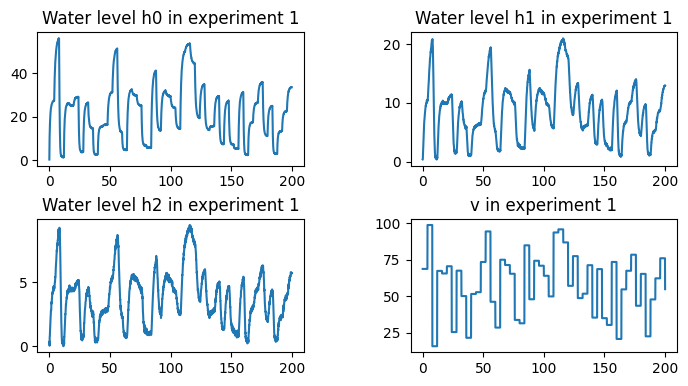

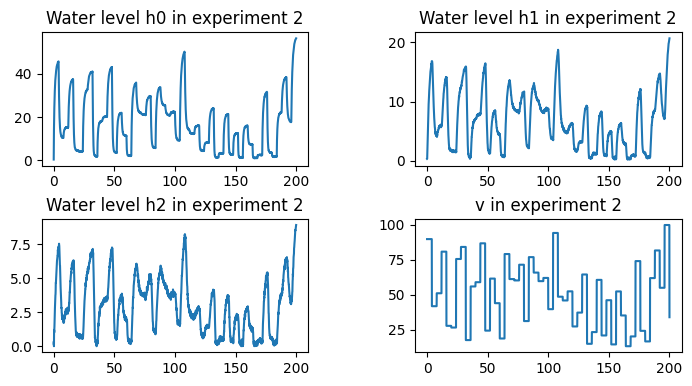

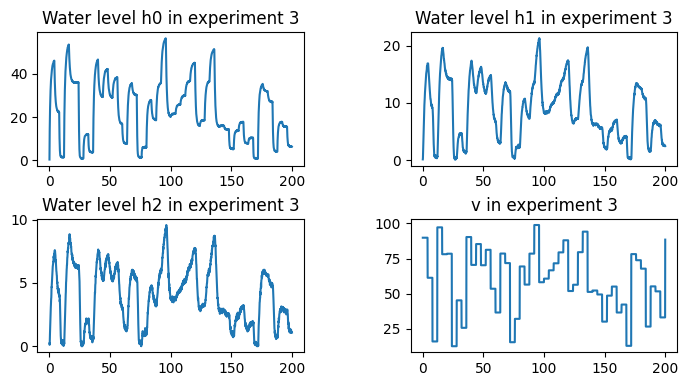

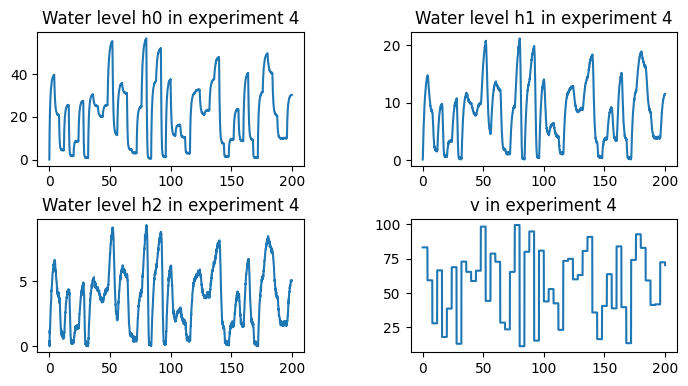

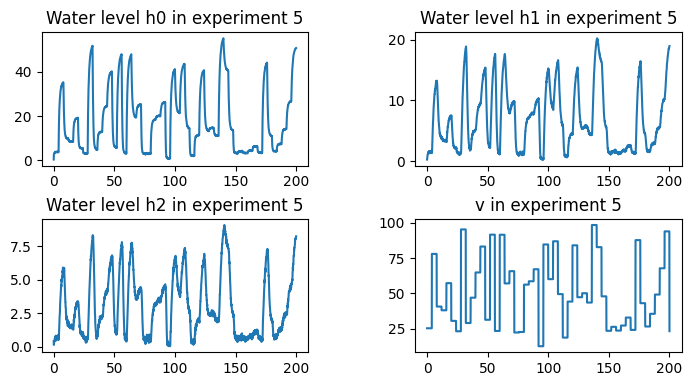

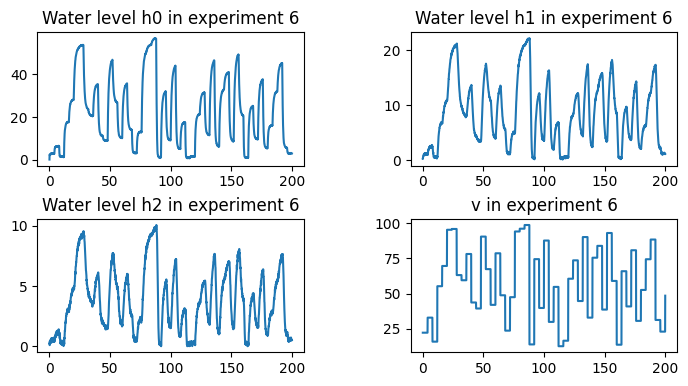

In [16]:
# Import Data
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'dataset_sysID_3tanks.mat')
data = scipy.io.loadmat(filepath)

dExp, yExp, dExp_val, yExp_val, Ts = data['dExp'], data['yExp'], \
    data['dExp_val'], data['yExp_val'], data['Ts'].item()
nExp = yExp.size

ny = np.shape(yExp[0,-1])[0]
nd = np.shape(dExp[0,-1])[0]

washout = 10 # washout datapoints in the loss

t = np.arange(0, np.size(dExp[0, 0], 1) * Ts-Ts, Ts)
t_end = yExp[0, 0].shape[1] - 1
t_end_val = yExp_val[0, 0].shape[1] 


for exp in range(nExp):
    y_exp = yExp[0,exp]
    d_exp = dExp[0,exp]
    plt.figure(figsize=(4 * 2, 4))
    for out in range(ny):
        plt.subplot(2, 2, out+1)
        plt.plot(t, y_exp[out,:])
        plt.title(r"Water level h%i "%out + r"in experiment %i"%(exp+1))
    plt.subplot(2, 2, ny+1)
    plt.plot(t, d_exp[1,:])
    plt.title(r"v in experiment %i"%(exp+1))
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
plt.show()

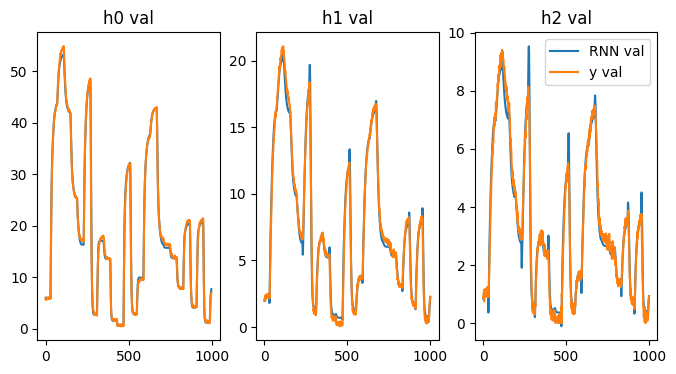

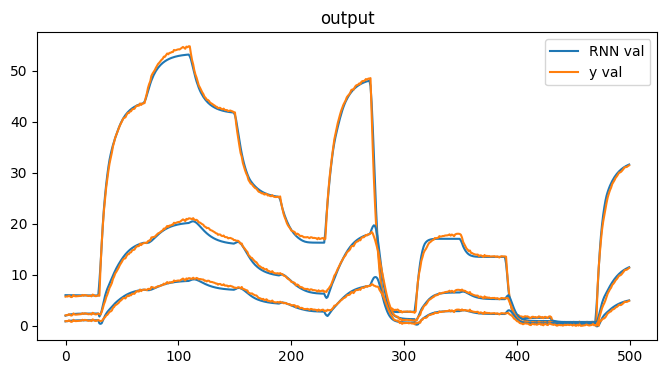

Loss Validation single RNN: 0.3090214729309082


In [17]:
# RNN model
# Define model again with the same architecture
checkpoint = torch.load('saved_models/RNN_checkpoint.pt', weights_only=False)
config = checkpoint['model_config']

RNN = RNNModel(config['idd'], config['hdd'], config['ldd'], config['odd'])
RNN.load_state_dict(checkpoint['model_state_dict'])
RNN.eval()

# Restore optimizer if needed
optimizerRNN = torch.optim.Adam(RNN.parameters(), lr=1.0e-4)  # LR can be overwritten
optimizerRNN.load_state_dict(checkpoint['optimizer_state_dict'])

# Optionally recover training info
loss_history_RNN = checkpoint['loss_history']
epoch_trained_RNN = checkpoint['epoch']

nExp_val = yExp_val.size
inputnumberD = 1

uval = torch.zeros(nExp_val, t_end_val, 1)
yval = torch.zeros(nExp_val, t_end_val, 3)

for j in range(nExp_val):
    inputActive = (torch.from_numpy(dExp_val[0, j])).T
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j])).T

yRNN_val = RNN(uval)
yRNN_val = torch.squeeze(yRNN_val)
MSE = nn.MSELoss()
loss_val_RNN = MSE(yRNN_val[washout:,:], torch.squeeze(yval)[washout:,:])


plot_time = t_end
plot_time = washout+1000
plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRNN_val[washout:plot_time,out].detach().numpy(), color='tab:blue', label='RNN val')
    plt.plot(yval[0, washout:plot_time,out].detach().numpy(), color='tab:orange', label='y val')
    plt.title(r"h%i"%out + r" val")  
plt.legend()
plt.show()

plot_time = washout+500
plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    if out == 0:
        plt.plot(yRNN_val[washout:plot_time,out].detach().numpy(), color='tab:blue', label='RNN val')
        plt.plot(yval[0, washout:plot_time,out].detach().numpy(), color='tab:orange', label='y val')
    else:
        plt.plot(yRNN_val[washout:plot_time,out].detach().numpy(), color='tab:blue')
        plt.plot(yval[0, washout:plot_time,out].detach().numpy(), color='tab:orange')
    plt.title(r"output")  
plt.legend()
plt.show()

pytorch_total_params_singleRNN = sum(p.numel() for p in RNN.parameters() if p.requires_grad)
print(f"Loss Validation single RNN: {loss_val_RNN}")


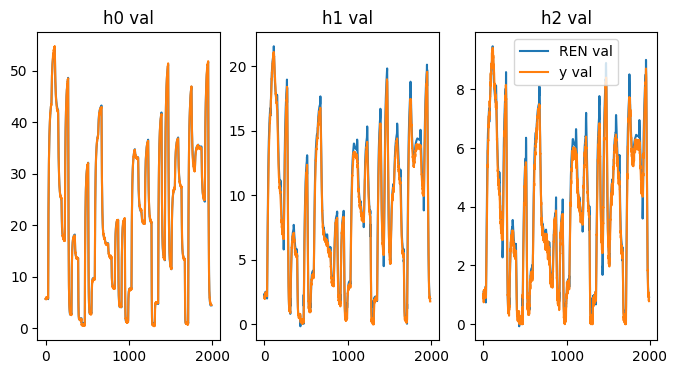

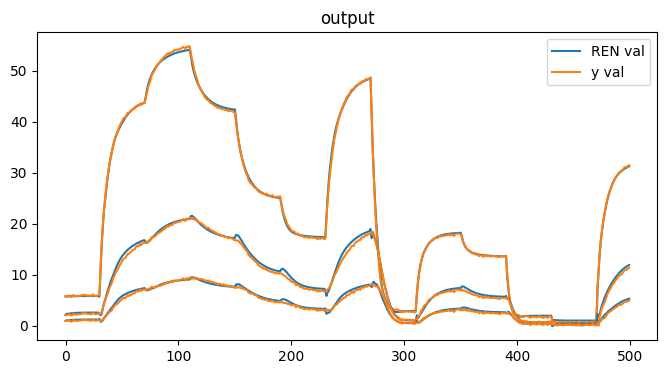

Loss Validation single REN: 0.17545399069786072


In [18]:
# Load checkpoint
checkpoint = torch.load('saved_models/single_REN_checkpoint.pt', weights_only=False)
config = checkpoint['model_config']

# Recreate the model
RENsys = REN(config['n'], config['p'], config['n_xi'], config['l'], gammaTrain=config['gammaTrain'])
RENsys.load_state_dict(checkpoint['model_state_dict'])
RENsys.eval()
RENsys.set_param()

# Reload optimizer (optional, if continuing training)
optimizerREN = torch.optim.Adam(RENsys.parameters(), lr=1.0e-3)  # You can overwrite LR if needed
optimizerREN.load_state_dict(checkpoint['optimizer_state_dict'])

# Additional info
n_xi = config['n_xi']
p = config['p']
loss_historyREN = checkpoint['loss_history']
epochs_trainedREN = checkpoint['epoch']

yval = torch.from_numpy(yExp_val[0, 0]).float().to(device)
yval = yval.squeeze()

yRENm_val = torch.zeros(p, t_end_val, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.from_numpy(dExp_val[0, 0]).float().to(device)
loss_val = 0
for t in range(1, t_end_val):
    u = torch.tensor([dval[inputnumberD, t]])
    yRENm_val[:, t], xiVal = RENsys(u, xiVal, t)
loss_val = loss_val + MSE(yRENm_val[:, washout:yRENm_val.size(1)], yval[:, washout:t_end_val])

loss_val_REN = loss_val

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRENm_val[out, washout:t_end].detach().numpy(), color='tab:blue', label='REN val')
    plt.plot(yval[out, washout:t_end].detach().numpy(), color='tab:orange', label='y val')
    plt.title(r"h%i"%out + r" val")  
plt.legend()
plt.show()

plot_time = washout+500
plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    if out == 0:
        plt.plot(yRENm_val[out, washout:plot_time].detach().numpy(), color='tab:blue', label='REN val')
        plt.plot(yval[out, washout:plot_time].detach().numpy(), color='tab:orange', label='y val')
    else:
        plt.plot(yRENm_val[out,washout:plot_time].detach().numpy(), color='tab:blue')
        plt.plot(yval[out, washout:plot_time].detach().numpy(), color='tab:orange')
    plt.title(r"output")  
plt.legend()
plt.show()

pytorch_total_params_singleREN = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)
print(f"Loss Validation single REN: {loss_val_REN}")

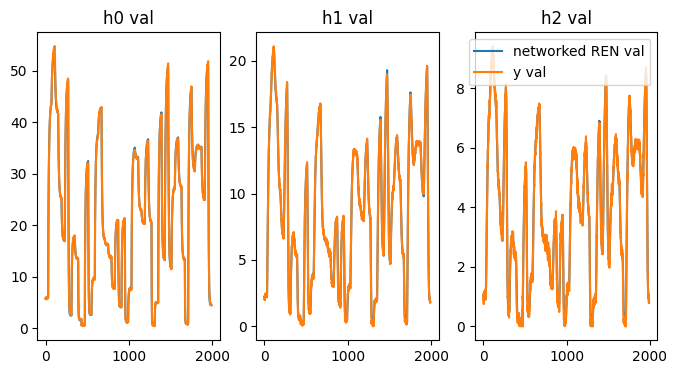

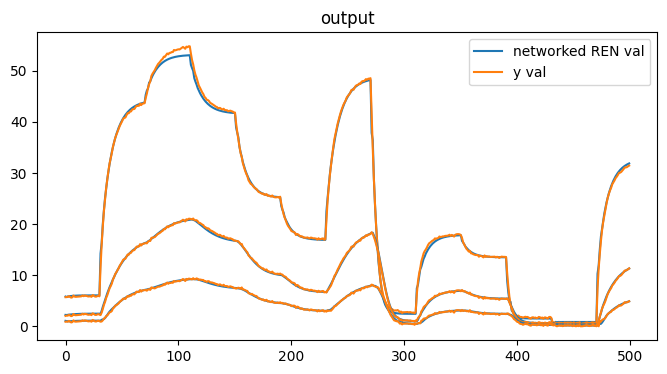

number of parameters single RNN: 3171
number of parameters single REN: 3353
number of parameters networked RENs: 3157
Loss Validation single RNN: 0.3090214729309082
Loss Validation single REN: 0.17545399069786072
Loss Validation networked RENs: 0.11885625123977661


In [19]:
# REN system with network
# Load checkpoint
checkpoint = torch.load('saved_models/networked_RENs_checkpoint.pt', weights_only=False)
config = checkpoint['model_config']

# Recreate model
RENsys = NetworkedRENs(
    config['N'],
    config['Muy'],
    config['Mud'],
    config['Mey'],
    config['n'],
    config['p'],
    np.array(config['n_xi']),
    np.array(config['l'])
)
RENsys.load_state_dict(checkpoint['model_state_dict'])
RENsys.eval()

# Reload optimizer (optional)
optimizerRENsys = torch.optim.Adam(RENsys.parameters(), lr=1e-3)  # can adjust LR if desired
optimizerRENsys.load_state_dict(checkpoint['optimizer_state_dict'])

# Load loss history and other info
N = config['N']

loss_historyRENsys = checkpoint['loss_history']
trained_epochsRENsys = checkpoint['epoch']
gamma_valsRENsys = checkpoint['gammas']



# Validation
xiVal =[]
yval = torch.from_numpy(yExp_val[0, 0]).float().to(device)
yval = yval.squeeze()
yRENm_val = torch.zeros(3, t_end_val, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
for j in range(N):
    xiVal.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
dval = torch.from_numpy(dExp_val[0, 0]).float().to(device)
xiVal = torch.cat(xiVal)
loss_val = 0
for t in range(1, t_end_val):
    yRENm_val[:, t], xiVal = RENsys(t, dval[:, t - 1], xiVal)
loss_val = loss_val + MSE(yRENm_val[:, washout:yRENm_val.size(1)], yval[:, washout:t_end_val])

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRENm_val[out, washout:t_end].detach().numpy(), color='tab:blue', label='networked REN val')
    plt.plot(yval[out, washout:t_end].detach().numpy(), color='tab:orange', label='y val')
    plt.title(r"h%i"%out + r" val")  
plt.legend()
plt.show()

plot_time = washout+500
plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    if out == 0:
        plt.plot(yRENm_val[out, washout:plot_time].detach().numpy(), color='tab:blue', label='networked REN val')
        plt.plot(yval[out, washout:plot_time].detach().numpy(), color='tab:orange', label='y val')
    else:
        plt.plot(yRENm_val[out,washout:plot_time].detach().numpy(), color='tab:blue')
        plt.plot(yval[out, washout:plot_time].detach().numpy(), color='tab:orange')
    plt.title(r"output")  
plt.legend()
plt.show()

pytorch_total_params_3RENs = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)


print(f"number of parameters single RNN: {pytorch_total_params_singleRNN}")
print(f"number of parameters single REN: {pytorch_total_params_singleREN}")
print(f"number of parameters networked RENs: {pytorch_total_params_3RENs}")

print(f"Loss Validation single RNN: {loss_val_RNN}")
print(f"Loss Validation single REN: {loss_val_REN}")
print(f"Loss Validation networked RENs: {loss_val}")

